### 1. Quick EDA and cleaning
### 2. Baseline with HistGradientBoostingClassifier
### 3. Initial Scoring of Classifiers
### 4. Hyperparams Tuning
### 5. Voting Ensemble

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

### 1. Data


In [3]:
data = pd.read_csv("/home/anopsy/Portfolio/juniors_chatgpt/data/comp_df.csv")

In [4]:
data.head()

,job_name,hours,remote,company_name,education,seniority,language,city,country,job_published_at,sample_date,comp_dol,all_tags
0,seniorprincipal engineer electrical,Full-Time,Unclear,0887 DS,Bachelors,Staff IC,en,NaN,United States,2023-04-17,2023,154800,Serverless Sigma Tools
1,lead algorithm engineer,Full-Time,Unclear,1000 KLA Corporation,Masters,Unclear Seniority,en,Ann Arbor,United States,2023-05-23,2023,123100,Linux ML Languages eCom OSS Stat OS C MATLAB T...
2,information technology support engineer,Full-Time,Unclear,Addnectar Solutions,Bachelors,Junior IC,en,Mumbai,India,2023-02-14,2024,28915,IT
3,systems and software development specialist,Full-Time,Unclear,Forge Group,Bachelors,Unclear Seniority,en,Reston,United States,2023-05-30,2023,95000,Hosting OSS PaaS Service Science App Stack Gov...
4,senior machine learning engineer,Full-Time,Unclear,260312-SOUTH FLORIDA REGION ADMIN,Unclear,Senior IC,en,Jersey City,United States,2024-02-27,2024,203625,OSS Stat Python Java Tools Languages PaaS IaaS...


In [5]:
data.dropna(inplace=True)

In [6]:
cat_type = ["hours","remote","education","seniority", "country"]
str_type = ["job_name"]
int_type = ["comp_dol"]

In [7]:
def cast_types(df):
    for col in df.columns:
        if col in cat_type:
            df[col] = df[col].astype("category")
        if col in str_type:
            df[col] = df[col].astype("str")
        if col in int_type:
            df[col] = df[col].astype("int64")


In [8]:
cast_types(data)

In [9]:
data.dtypes

job_name              object
hours               category
remote              category
company_name          object
education           category
seniority           category
language              object
city                  object
country             category
job_published_at      object
sample_date            int64
comp_dol               int64
all_tags              object
dtype: object

In [10]:
data_pred = data[["job_name", "hours","remote","education","seniority", "country", "comp_dol"]]
for col in cat_type:
    print(data_pred[col].value_counts())

hours
Full-Time     6549
Unclear       1586
Part-Time      509
Contract       239
Hourly         178
Intern          88
Temp            75
Gig              5
Student          5
Trainee          5
Grant            4
Advisor          2
Commission       1
Name: count, dtype: int64
remote
Unclear    7507
true        962
false       777
Name: count, dtype: int64
education
Unclear                     4668
Bachelors                   2812
High School                 1238
Some High School             208
Masters                      151
Doctorate                    137
Associates                    13
Vocational                    11
No Education Requirement       8
Name: count, dtype: int64
seniority
Unclear Seniority    5206
Senior IC            1584
Manager               773
IC                    620
Junior IC             363
Staff IC              316
Intern                151
Director               73
Chief                  71
Contract               37
Exec                   29
Senior Mana

In [11]:
data_pred.columns

Index(['job_name', 'hours', 'remote', 'education', 'seniority', 'country',
       'comp_dol'],
      dtype='object')

In [12]:
def shorten_categories(categories, cutoff, replace):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = replace
    return categorical_map

In [13]:
country_map = shorten_categories(data_pred.country.value_counts(), 10, "Other")
data_pred["country"] = data_pred["country"].map(country_map)
data_pred.country.value_counts()

/tmp/ipykernel_9652/2122512135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred["country"] = data_pred["country"].map(country_map)


country
United States     6943
India              706
United Kingdom     399
Other              182
Canada             180
Austria            110
Brazil              95
France              90
Germany             77
Australia           65
South Africa        60
Romania             51
China               49
Netherlands         44
Lithuania           21
Mexico              21
Singapore           17
Israel              17
Spain               16
Italy               16
Japan               15
New Zealand         11
Philippines         11
Argentina           10
Poland              10
Malaysia            10
Ireland             10
Cuba                10
Name: count, dtype: int64

In [14]:
hours_map = shorten_categories(data_pred.hours.value_counts(), 70, "Unclear")
data_pred["hours"] = data_pred["hours"].map(hours_map)
data_pred.hours.value_counts()

/tmp/ipykernel_9652/1901674562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred["hours"] = data_pred["hours"].map(hours_map)


hours
Full-Time    6549
Unclear      1608
Part-Time     509
Contract      239
Hourly        178
Intern         88
Temp           75
Name: count, dtype: int64

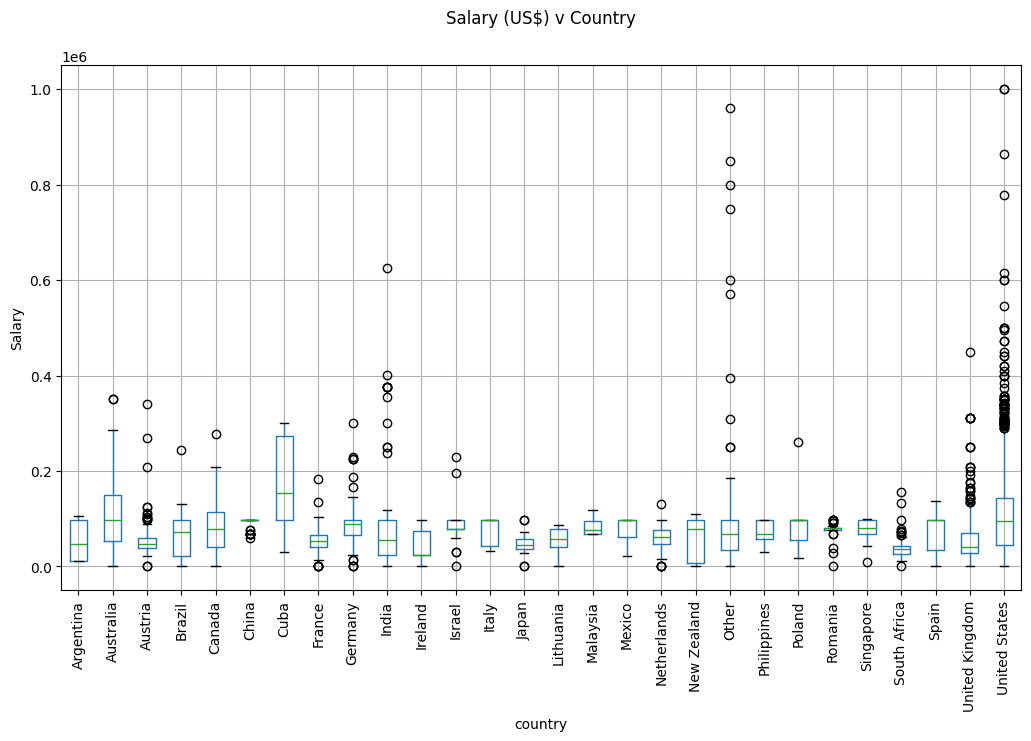

In [16]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
data_pred.boxplot('comp_dol', 'country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

job_name
security officer                      117
senior software engineer               70
security guard                         69
software engineer                      66
program manager                        39
product manager                        37
project engineer                       33
network engineer                       31
data analyst                           30
data engineer                          29
unarmed security officer               27
electrical engineer                    27
mechanical engineer                    27
data scientist                         26
manufacturing engineer                 24
senior devops engineer                 24
security officer - armed               23
android developer                      22
systems engineer                       21
retail security officer                21
target security specialist             21
junior data scientist - dubai, uae     21
senior data engineer                   20
devops engineer          

### 2. Baseline with different Regressors
#### Using HistGradientBoostingClassifier to get an initial idea of my pipeline and baseline results

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, KFold, ValidationCurveDisplay, cross_validate
from sklearn.base import TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error,  mean_absolute_error, r2_score 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn import svm

In [18]:
scaler = StandardScaler()
X = data_pred.drop(columns=["comp_dol"]) #all_tags
y = data_pred[["comp_dol"]]
y_trans = scaler.fit_transform(y)
kf = KFold(n_splits=5, shuffle = True, random_state = 2137)
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size = 0.2, shuffle=True, random_state = 2137)

In [19]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

In [20]:
col_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_type),
    (CountVectorizer(stop_words="english"), "job_name"), 
)

### 3. Initial Scoring of Classifiers
#### Let's try different estimators and compare their results

In [21]:
models = [
    ('xgb', XGBRegressor(verbose=0)),
    ('lgbm', LGBMRegressor(verbosity=-1)),
    ('cat', CatBoostRegressor(silent=True)),
    ('svr_lin', svm.SVR(kernel="linear")),
    ('svr_rbf', svm.SVR(kernel="rbf")),
    ('sgd', SGDRegressor(loss='squared_error', penalty='l2')),
    ('rf', RandomForestRegressor()),
]

In [22]:
metrics={
    'mse':make_scorer(mean_squared_error),
    'mae':make_scorer(mean_absolute_error), 
    'r2':make_scorer(r2_score)
}

In [23]:
def build_pipes(models, column_transformer):
    pipes = {}
    for model in models:
        pipe = Pipeline(steps = [('data_prep', col_transformer), model], verbose=False)
        pipes[model[0]] = pipe
    return pipes

In [24]:
def score_cv(estimators,n_splits=5,metrics=metrics):
    scorers=[]
    for pipe_name in pipes.keys():
        pipe=pipes[pipe_name]
        kf = KFold(n_splits)
        model_score=cross_validate(pipe, X_train, y_train, scoring=metrics, cv=kf)
        scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric] = [score['test_' + metric] for score in scorers]
        
    return score_lists


In [25]:
def plot_scores(score_lists, labels):
    for  i,(title, list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=list, palette='hls').set_xticklabels(labels, rotation=45)
        plt.title(title)
        plt.savefig('/home/anopsy/Portfolio/juniors_chatgpt/model/fin_model_plots/'+title+'_score.png', dpi=150)

In [26]:
def plot_learning_curves(pipelines):
    for clf_name in pipes.keys():
        train_size_abs, train_scores, test_scores = learning_curve(
        pipes[clf_name], X_train, y_train, train_sizes=[0.2, 0.4, 0.6, 0.8, 1], cv=kf, scoring='r2')
    
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
    
        plt.figure(figsize=(10, 6))
        plt.plot(train_size_abs, train_mean, label="Training score", color="darkcyan", marker='o')
        plt.fill_between(
            train_size_abs,
            train_mean - train_std,
            train_mean + train_std,
            alpha=0.1,
            color="aqua",
        )
        plt.plot(train_size_abs, test_mean, label="Test score", color="mediumorchid", marker='o')
        plt.fill_between(
            train_size_abs,
            test_mean - test_std,
            test_mean + test_std,
            alpha=0.1,
            color="fuchsia",
        )

        plt.xlabel("Number of training samples")
        plt.ylabel("Score")
        plt.title(clf_name + "_learning curves R2")
        plt.legend(loc="best")
        plt.grid(True)
        plt.savefig('/home/anopsy/Portfolio/juniors_chatgpt/model/fin_model_plots/'+clf_name + "curves R2.png")
        plt.show()
    

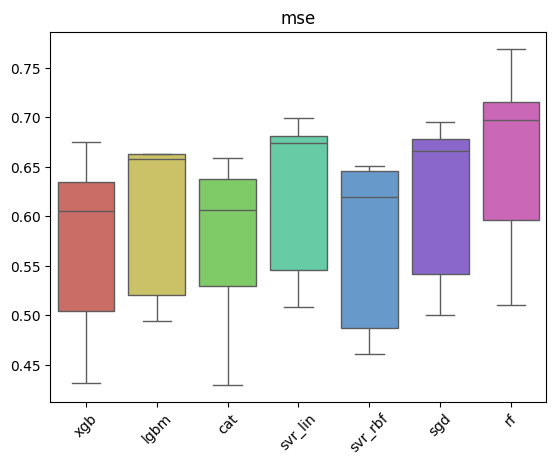

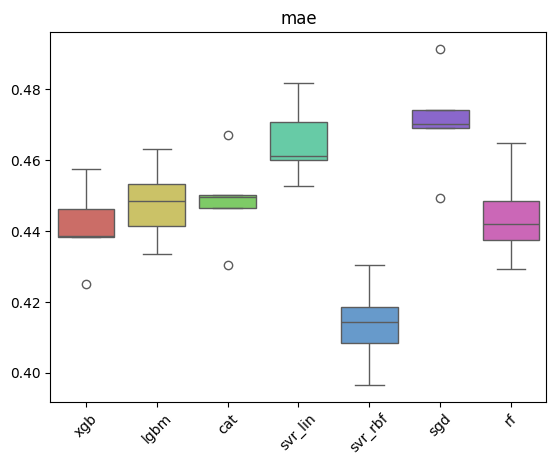

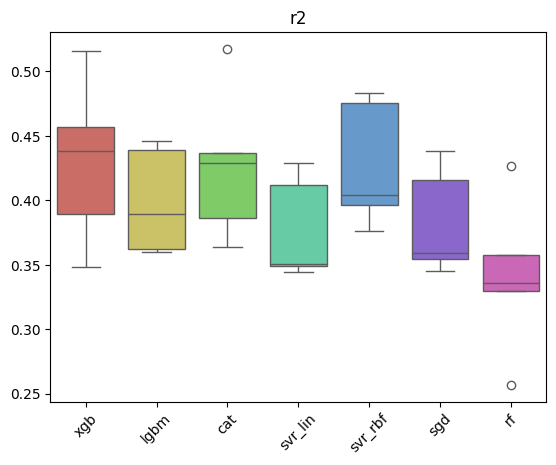

In [27]:
pipes = build_pipes(models, col_transformer)
score_lists = score_cv(pipes)
labels = pipes.keys()
plot_scores(score_lists, labels)

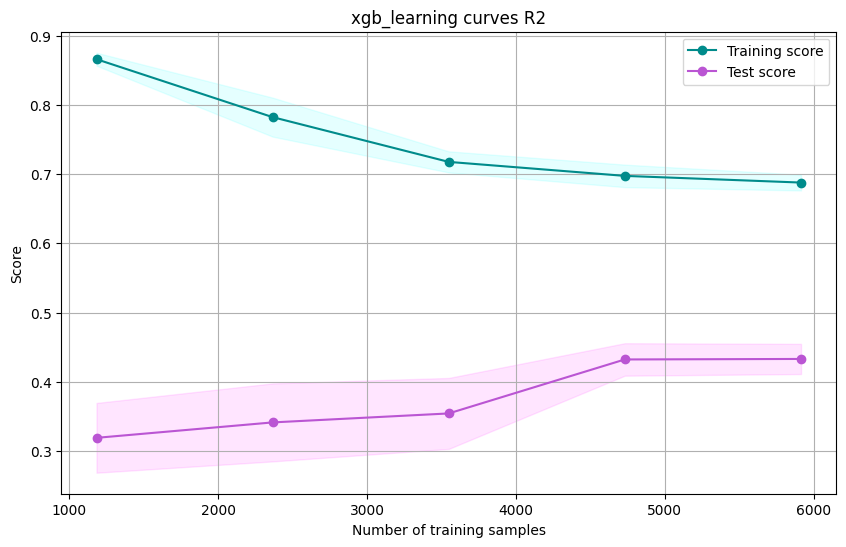

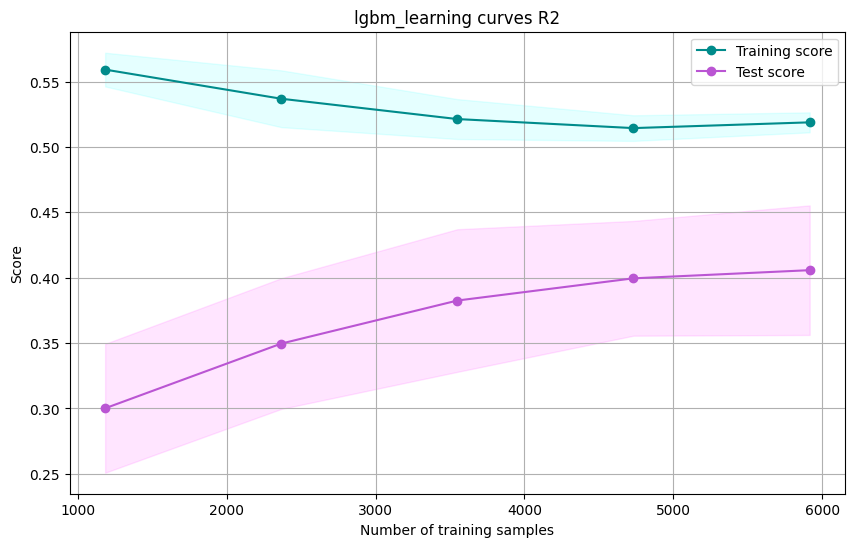

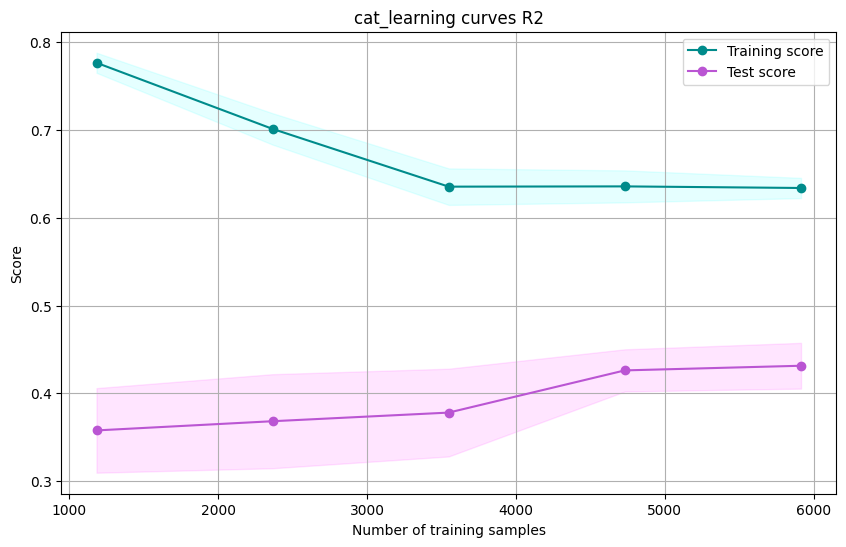

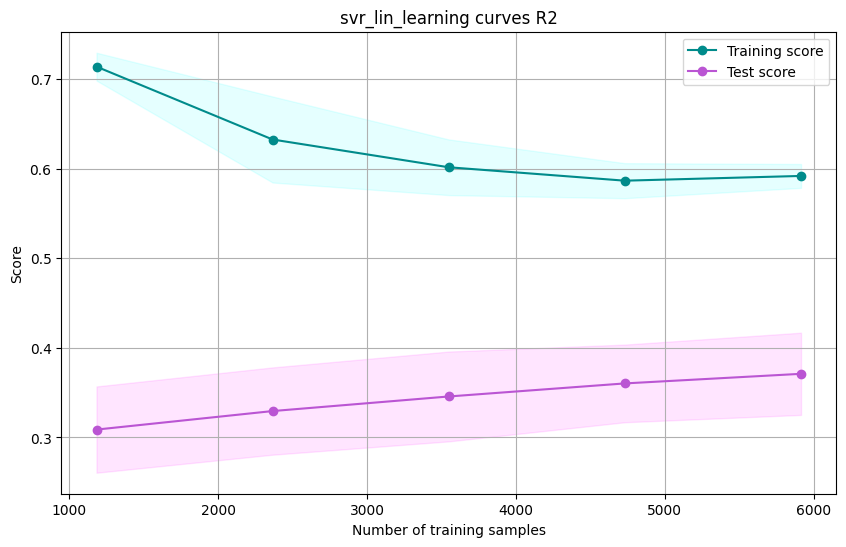

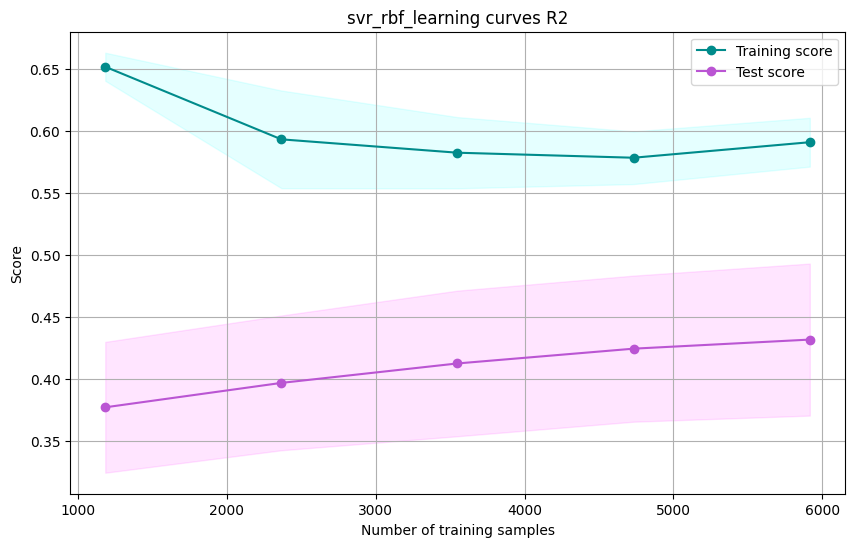

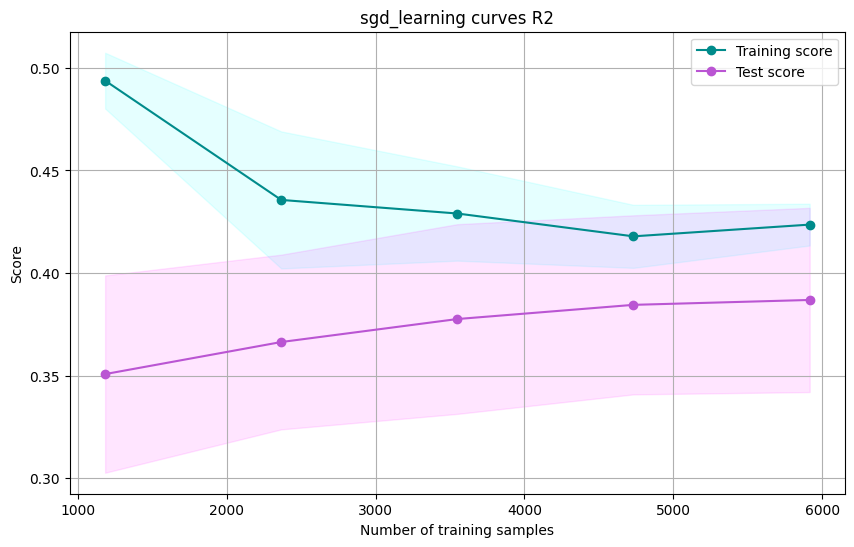

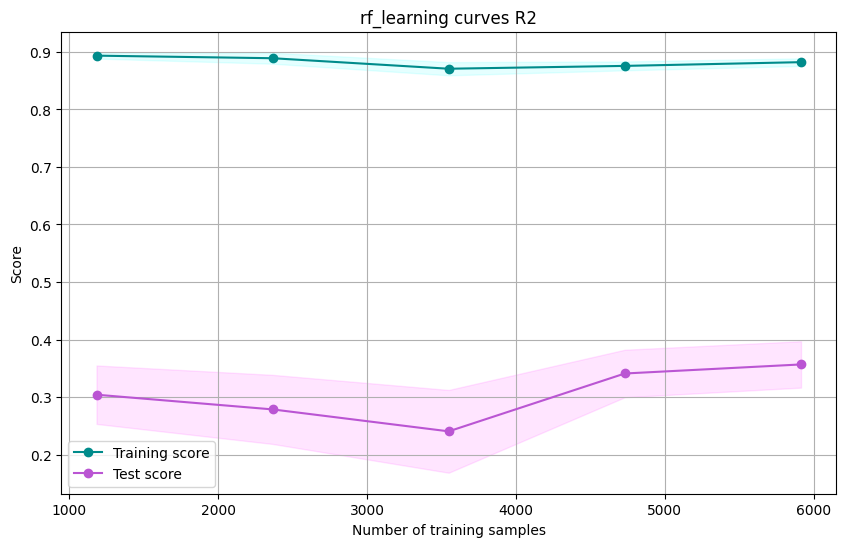

In [28]:
plot_learning_curves(pipes)

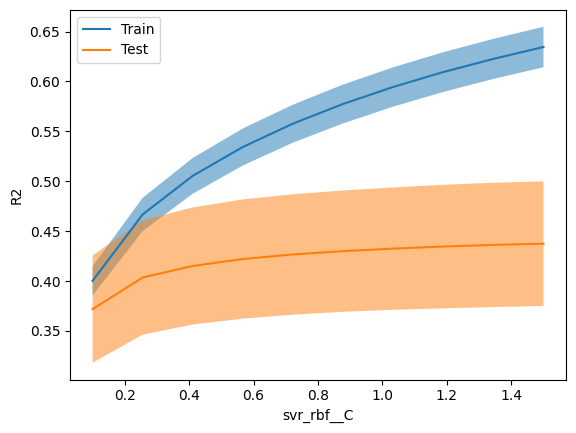

In [29]:
ValidationCurveDisplay.from_estimator(
   pipes['svr_rbf'], X_train, y_train, param_name='svr_rbf__C', param_range=np.linspace(0.1, 1.5, 10),  cv=kf, scoring='r2'
)

In [30]:
pipes['svr_rbf'].named_steps['data_prep'].fit_transform(X_train)

<7396x3769 sparse matrix of type '<class 'numpy.float64'>'
	with 66297 stored elements in Compressed Sparse Row format>

In [31]:
model_fin = pipes['svr_rbf']

In [ ]:
data_pred.iloc[0]

In [32]:
model_fin.fit(X_train, y_train)

Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['hours', 'remote',
                                                   'education', 'seniority',
                                                   'country']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'job_name')])),
                ('svr_rbf', SVR())])

In [33]:
model_fin.predict(np.array([["lead algorithm engineer", "Full-Time", "Unclear", "Masters", "Unclear Seniority", "United States"]]))

ValueError: Specifying the columns using strings is only supported for dataframes.

In [33]:
pipes.predict(["lead algorithm engineer", "Full-Time", "Unclear", "Masters", "Unclear Seniority", "United States"])

AttributeError: 'dict' object has no attribute 'predict'

In [34]:
df_predict = pd.DataFrame({
    "job_name": ["lead algorithm engineer"],
    "hours": ["Full-Time"],
    "remote": ["Unclear"],
    "education": ["Masters"],
    "seniority":["Unclear Seniority"], 
    "country":["United States"],
})

In [35]:
salary = model_fin.predict(df_predict)

In [36]:
scaler.inverse_transform([salary])

array([[130272.30261917]])

In [37]:
df_predict = pd.DataFrame({
    "job_name": ["frontend developer"],
    "hours": ["Full-Time"],
    "remote": ["true"],
    "education": [None],
    "seniority":["Junior IC"], 
    "country":["Poland"],
})

In [38]:
scaler.inverse_transform([model_fin.predict(df_predict)])

array([[55637.55226185]])

In [59]:
data.remote.value_counts()

remote
Unclear    7507
true        962
false       777
Name: count, dtype: int64

In [40]:
from joblib import dump, load

dump(model_fin, '/home/anopsy/Portfolio/comp_app/rbf_model.joblib')

In [41]:
dump(model_fin, '/home/anopsy/Portfolio/comp_app/rbf_model.joblib')

['/home/anopsy/Portfolio/comp_app/rbf_model.joblib']

In [42]:
dump(scaler, '/home/anopsy/Portfolio/comp_app/scaler.joblib')

['/home/anopsy/Portfolio/comp_app/scaler.joblib']

In [43]:
scaler_loaded = load('/home/anopsy/Portfolio/comp_app/scaler.joblib')

In [44]:
scaler_loaded.inverse_transform([model_fin.predict(df_predict)])

array([[55637.55226185]])